# Solving the Travelling Salesman problem using Simulated Annealing

In [1]:
import numpy as np
import math
import itertools
import random
import matplotlib.pyplot as plt
import scipy.stats as stats

/home/mia/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


As our benchmark dataset we will use the famous TSPLIB 95 [Euclidean Symmetrical Instances](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/). The solver expects that the uncompressed files are available in the folder `ALL_tsp`. We start by converting `.tsp` files into a distance matrix $A$, such that $a_{i, j}$ corresponds to the distance between cities $i$ and $j$. Since we are dealing with symmetrical instances, the matrix is also symmetric.

In [2]:
def dist_arr(file_path):
    x_coord = []
    y_coord = []

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            

            if line.startswith("EDGE_WEIGHT_TYPE"):
                if not line.endswith("EUC_2D"):
                    print("Error Incompatible Types")
                    break

            if line[0].isdigit():
                x_coord.append(float(line.split()[1]))  
                y_coord.append(float(line.split()[2]))

    dist = np.zeros((len(x_coord), len(x_coord)))

    for i in range(len(x_coord)):
        for j in range(len(x_coord)):
            dist[i, j] = math.dist([x_coord[i], y_coord[i]], [x_coord[j], y_coord[j]])

    return dist

In [3]:
dist = dist_arr("ALL_tsp/a280.tsp")
print(dist[0:9, 0:9])

[[ 0.         20.         24.08318916 32.984845   32.984845   42.75511665
  55.71355311 63.2455532  61.18823416]
 [20.          0.         18.43908891 34.17601498 42.52058325 50.47771786
  65.60487787 72.11102551 68.        ]
 [24.08318916 18.43908891  0.         16.1245155  27.78488798 33.9411255
  49.51767361 55.31726674 50.47771786]
 [32.984845   34.17601498 16.1245155   0.         16.         18.86796226
  34.40930107 39.59797975 34.40930107]
 [32.984845   42.52058325 27.78488798 16.          0.         10.
  23.32380758 30.46309242 28.28427125]
 [42.75511665 50.47771786 33.9411255  18.86796226 10.          0.
  15.62049935 21.63330765 18.43908891]
 [55.71355311 65.60487787 49.51767361 34.40930107 23.32380758 15.62049935
   0.          8.         11.3137085 ]
 [63.2455532  72.11102551 55.31726674 39.59797975 30.46309242 21.63330765
   8.          0.          8.        ]
 [61.18823416 68.         50.47771786 34.40930107 28.28427125 18.43908891
  11.3137085   8.          0.        ]]

As a utility function, we now define `full_dist` to calculate the total length of a given route. We encode it as a vector, such that the $i$-th element is the $i$-th city we visit on our tour.

In [4]:
def full_dist(dist, route):
    total = 0
    for i in range(len(route)):
        total += dist[route[i], route[(i+1) % len(route)]]

    return total
    

We start with a simple random search to gain some intuition about the search space. The following function will generate `lim` many random routes and identify the shortest one among them.

In [5]:
def random_routes(dist, lim):
    route = list(range(0, len(dist)))

    total = math.inf
    route_opt = None
    t = 0
    while t <= lim:
        random.shuffle(route)

        if full_dist(dist, route) < total:
            total = full_dist(dist, route)
            route_opt = route
        t += 1
      

    return total, route_opt

In [6]:
print(random_routes(dist, 10**3))

(30740.6698039102, [5, 164, 221, 44, 59, 269, 112, 34, 85, 226, 29, 214, 73, 81, 169, 38, 213, 212, 227, 54, 155, 69, 142, 56, 144, 202, 177, 158, 105, 99, 236, 244, 122, 97, 171, 241, 197, 21, 60, 92, 27, 133, 250, 0, 13, 57, 251, 152, 41, 196, 118, 24, 223, 70, 204, 23, 156, 100, 228, 78, 93, 125, 19, 181, 40, 43, 71, 16, 185, 189, 58, 207, 224, 198, 131, 76, 90, 134, 159, 107, 111, 46, 45, 18, 135, 65, 2, 166, 191, 148, 183, 80, 102, 150, 61, 6, 37, 31, 246, 91, 33, 215, 167, 114, 66, 262, 28, 48, 264, 237, 220, 161, 230, 79, 98, 72, 232, 141, 179, 235, 75, 64, 193, 42, 258, 234, 74, 139, 211, 128, 68, 26, 192, 95, 120, 217, 174, 203, 83, 254, 248, 130, 190, 63, 22, 260, 180, 121, 173, 12, 261, 129, 101, 117, 271, 157, 151, 276, 113, 218, 256, 67, 145, 154, 163, 162, 110, 8, 62, 182, 199, 219, 116, 146, 25, 275, 178, 49, 11, 47, 109, 50, 132, 126, 186, 170, 209, 136, 51, 205, 187, 270, 208, 195, 267, 184, 89, 96, 274, 188, 243, 245, 206, 278, 3, 53, 252, 216, 17, 222, 263, 247, 10, 

For Simulated Annealing we need to define a `step` function, which mutates our current tour. Our implementation chooses a uniformly random 2-OPT move, which are described in greater detail [here](https://jmsallan.netlify.app/blog/2-opt-moves-in-the-travelling-salesman-problem/). This mutation is known to work well in practice.

In [7]:
def step(dist, route):
    # uniformly random select two non-adjacent edges
    idx_edge_1_start = random.randrange(len(route))
    idx_edge_1_end = (idx_edge_1_start + 1) % len(route)

    idx_edge_2_start = random.randrange(len(route))
    idx_edge_2_end = (idx_edge_2_start + 1) % len(route)

    while abs(idx_edge_1_start - idx_edge_2_start) <= 1:
        idx_edge_2_start = random.randrange(len(route))
        idx_edge_2_end = (idx_edge_2_start + 1) % len(route)

    # ensure first edge is before second edge
    if idx_edge_2_start < idx_edge_1_start:
        idx_edge_1_start, idx_edge_2_start = idx_edge_2_start, idx_edge_1_start
        idx_edge_1_end, idx_edge_2_end = idx_edge_2_end, idx_edge_1_end

    # full_dist(before) - full_dist(after)
    diff = dist[route[idx_edge_1_start], route[idx_edge_1_end]] + dist[route[idx_edge_2_start], route[idx_edge_2_end]] - dist[route[idx_edge_1_start], route[idx_edge_2_start]] - dist[route[idx_edge_1_end], route[idx_edge_2_end]]

    route_new = []
    route_new += route[0 : idx_edge_1_start+1]
    route_new += list(reversed(route[idx_edge_1_end : idx_edge_2_start + 1]))
    if idx_edge_2_end != 0:
        route_new += route[idx_edge_2_end :]

    return diff, route_new

Now we have everything we need to implement the [Simulated Annealing](https://en.wikipedia.org/wiki/Simulated_annealing) search.

In [8]:
def sim_ann(dist, initial_route, initial_temp):
    cooling_rate = 0.0001
    final_temp = 1e-3
    it = 0

    route = initial_route
    distance = full_dist(dist, route)

    temp = initial_temp

    while temp > final_temp and it <= 1_000_000:
        diff, route_new = step(dist, route)
        
        if diff <= 0:
            if -diff/temp <= 0:
                if random.random() > math.exp(-diff/temp):
                    route = route_new
                    distance -= diff

        else:
            route = route_new
            distance -= diff
        it += 1
        temp *= 1.0 - cooling_rate

    return distance, route

As an example, we run this function with a randomised route as a starting point. The initial temperature is chosen using the common strategy $-\frac{\mu(f)}{\ln(0.8)}$, where we estimate the average length $\mu(f)$ using our random search. We can see that the route is more than ten times shorter than the one provided by `random_routes`.

In [9]:
route = list(range(0, len(dist)))
random.shuffle(route)

print(sim_ann(dist, route, 150_000.0))

(2947.7328096325227, [58, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 94, 95, 96, 97, 92, 93, 79, 80, 88, 81, 78, 75, 86, 84, 83, 82, 87, 108, 89, 90, 91, 98, 99, 100, 101, 102, 168, 167, 166, 169, 171, 170, 165, 164, 187, 188, 189, 190, 191, 193, 194, 195, 200, 201, 202, 203, 204, 212, 215, 214, 217, 216, 219, 220, 221, 218, 222, 223, 224, 225, 213, 210, 209, 211, 206, 205, 207, 208, 251, 252, 253, 254, 255, 256, 257, 248, 247, 249, 250, 229, 228, 227, 226, 232, 233, 234, 235, 231, 230, 236, 237, 238, 245, 244, 239, 240, 243, 246, 242, 241, 1, 0, 279, 2, 277, 278, 3, 276, 275, 4, 5, 6, 7, 8, 9, 10, 11, 14, 12, 13, 16, 17, 132, 133, 134, 135, 267, 268, 269, 15, 270, 271, 272, 273, 274, 260, 259, 258, 261, 262, 263, 264, 265, 266, 136, 137, 148, 138, 139, 140, 147, 146, 141, 142, 145, 144, 143, 199, 198, 197, 196, 192, 185, 186, 184, 163, 162, 161, 160, 183, 182, 181, 180, 175, 176, 179, 178, 149, 177, 150, 151,

We find that our function for Simulated Annealing provides better solutions when it is provided with a heuristic starting route. Therefore, we implement the `greedy` function, which chooses the shortest available edge at every step.

In [10]:
def greedy(dist, route_part=[0]):
    route = route_part
    
    for i in range(len(route_part), len(dist)):
        min_edge = math.inf
        min_idx = -1
        for j in range(0, len(dist)):
            if dist[route[-1], j] < min_edge and j not in route:
                min_edge = dist[route[-1], j]
                min_idx = j

        route.append(min_idx)
            
    return route

In [11]:
route = greedy(dist)

print(full_dist(dist, route), route)

3148.109934934404 [0, 279, 1, 2, 278, 277, 3, 276, 275, 274, 273, 272, 271, 270, 15, 16, 17, 18, 19, 20, 127, 126, 125, 124, 29, 30, 31, 28, 27, 26, 25, 21, 24, 22, 23, 13, 12, 11, 10, 9, 7, 6, 8, 5, 4, 259, 258, 257, 256, 253, 252, 207, 206, 209, 208, 251, 254, 255, 248, 247, 246, 243, 240, 239, 238, 237, 230, 231, 232, 233, 234, 235, 236, 245, 244, 249, 250, 229, 228, 227, 226, 225, 224, 223, 222, 221, 218, 217, 214, 213, 210, 211, 212, 215, 216, 219, 220, 202, 201, 199, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 269, 268, 267, 266, 265, 264, 263, 262, 261, 260, 14, 132, 131, 130, 129, 128, 153, 154, 152, 155, 151, 150, 176, 175, 180, 179, 178, 177, 149, 148, 147, 146, 145, 144, 198, 197, 196, 193, 194, 195, 200, 192, 191, 190, 189, 188, 187, 186, 184, 183, 182, 181, 160, 161, 162, 163, 164, 165, 166, 167, 168, 100, 99, 98, 97, 92, 93, 94, 95, 96, 91, 90, 89, 88, 108, 107, 103, 102, 101, 169, 170, 171, 172, 105, 104, 106, 173, 174, 159, 158, 157, 156, 118, 119, 120, 121, 

To show the improvement that `greedy` provides for Simulated Annealing, we now compare the results of `sim_ann` using both a random starting route and a greedy starting route in a plot. A greedy initial route provides consistently better routes than a random one.

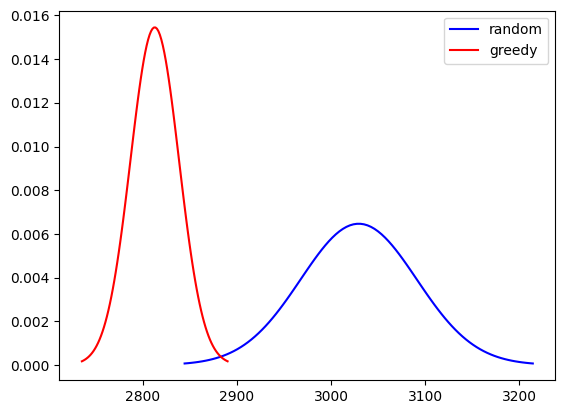

In [15]:
def plot_results(dist):
    results = []
    for i in range(0, 20):
        route = list(range(0, len(dist)))
        random.shuffle(route)
        results.append(sim_ann(dist, route, 150_000.0)[0])

    results2 = []
    for i in range(0, 20):
        route = greedy(dist)
        results2.append(sim_ann(dist, route, 150_000.0)[0])
    
    variance = np.var(results)
    mu = np.mean(results)
    sigma = math.sqrt(variance)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), 'b', label="random")
    variance2 = np.var(results2)
    mu2 = np.mean(results2)
    sigma2 = math.sqrt(variance2)
    x2 = np.linspace(mu2 - 3*sigma2, mu2 + 3*sigma2, 100)
    plt.plot(x2, stats.norm.pdf(x2, mu2, sigma2), 'r', label="greedy")
    plt.legend(loc="upper right")
    plt.show()

plot_results(dist)

(c) Julian Hein